(sec:sgd)=
# Optimization

In this chapter, we will present variants of the **Gradient Descent** optimization strategy and show how they can be used to optimize neural network parameters.

Let us start with the basic Gradient Descent algorithm and its limitations.

**TODO: Include Algo here**

As one can see in the previous algorithm, in the Gradient Descent algorithm, model parameters are updated once per epoch, which means a full pass over the whole dataset is required before the update can occur.
When dealing with large datasets, this is a strong limitation, which motivates the use of stochastic variants.

## Stochastic Gradient Descent (SGD)

The idea behind the Stochastic Gradient Descent algorithm is to get cheap estimates for the quantity $\nabla_w \mathcal{L}(X, y ; m_\theta)$.
To do so, one draws subsets of data, called _minibatches_, and $\nabla_w \mathcal{L}(X_\text{minibatch}, y_\text{minibatch} ; m_\theta)$ is used as an estimator for this quantity.
This results in the following algorithm in which, interestingly, parameter updates occur after each minibatch, which is multiple times per epoch.

**TODO: Include Algo here**

**TODO: include animation GD vs SGD here**


Apart from beneficing from more frequent parameter updates, SGD has an extra benefit in terms of optimization, which is key for neural networks.
Indeed, as one can see below, contrary to what we had in the Perceptron case, the MSE loss (and teh same applies for the logistic loss) is no longer convex in the model parameters as soon as the model has at least one hidden layer:

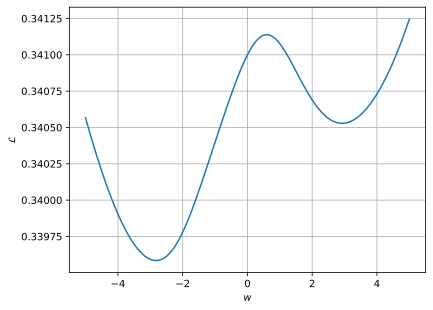

In [1]:
import numpy as np

%config InlineBackend.figure_format = 'svg'
%matplotlib inline
import matplotlib.pyplot as plt

plt.ion();

def sigmoid(x):
    return 1. / (1. + np.exp(-x))

def model_forward_loss(weights, biases, X, y):
    outputs = X
    for w, b in zip(weights, biases):
        outputs = sigmoid(outputs @ w + b)
    loss = np.mean((outputs - y) ** 2)
    loss += .0001 * np.sum([(w ** 2).sum() for w in weights])
    return loss


np.random.seed(0)
w0 = np.linspace(-5, 5, 100)
X = np.random.randn(150, 6)
y = np.array([0] * 75 + [1] * 75)
weights = [
    np.random.randn(6, 20),
    np.random.randn(20, 1)
]
biases = [
    np.random.randn(1, 20),
    np.random.randn(1, 1)
]

losses = []
for wi in w0:
    weights[0][3, 9] = wi
    losses.append(model_forward_loss(weights, biases, X, y))


plt.plot(w0, losses)
plt.grid('on')
plt.xlabel('$w$')
plt.ylabel('$\mathcal{L}$');

Gradient Descent is known to suffer from local optima, and such loss landscapes are a serious problem for GD.
On the other hand, Stochastic Gradient Descent is likely to benefit from noisy gradient estimations to escape local minima.

## A note on Adam

**TODO: formulas**

**TODO: illustrate SGD, SGD+momentum, Adam on a given optimization problem**

## The curse of depth

**TODO:** MLP illustration with colors and chain rule

**TODO:** A first implication: use ReLU activation functions if you have no reason to use anything else. (illustrate this?)

**TODO**: talk about feature standardization and how it eases the convergence to a good solution